# Mobile Robotics Project Report
### **Group 31:** Chiara Delvecchio, Camille Dorster, Junseo Um, Jérôme Courdacy

**Task Distribution**:  
Chiara:  
Camille:  
Junseo: Kalman filter
Jérôme:  

# Table of contents

## Introduction

Talk about the environment and choices we made.

## Vision

In [ ]:
import cv2
import matplotlib.pyplot as plt
from vision_utils import Vision

CAMERA_INDEX = 1
CAMERA_WIDTH = 1920
CAMERA_HEIGHT = 1080
MAP_WIDTH = 700
MAP_HEIGHT = 500
MATRIX_FILE_PATH = "calibration_matrix.npy"
THYMIO_MARKER_ID = 0
GOAL_MARKER_ID = 1
MIN_OBSTACLE_AREA = 100

create vision object (calibration)

In [ ]:
vision = Vision(
        camera_index=CAMERA_INDEX,
        cam_width=CAMERA_WIDTH,
        cam_height=CAMERA_HEIGHT,
        map_width=MAP_WIDTH,
        map_height=MAP_HEIGHT,
        matrix_file_path=MATRIX_FILE_PATH,
        thymio_marker_id=THYMIO_MARKER_ID,
        goal_marker_id=GOAL_MARKER_ID,
        min_obstacle_area=MIN_OBSTACLE_AREA,
    )


Webcam 1 opened successfully.
Loaded perspective transform matrix from calibration_matrix.npy.


raw frame explanation

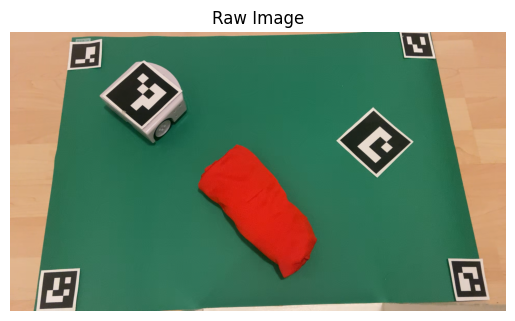

In [ ]:
raw_frame = vision.get_raw_frame()

plt.imshow(cv2.cvtColor(raw_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Raw Frame')
plt.show()

perspective calibration explanation

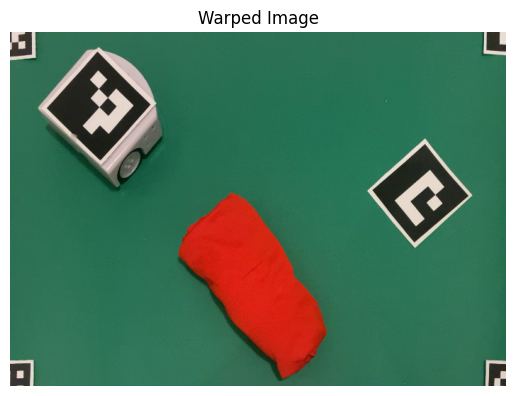

In [ ]:
warped_frame = vision.get_warped_frame()

plt.imshow(cv2.cvtColor(warped_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Warped Frame')
plt.show()

obstacle detection explanation

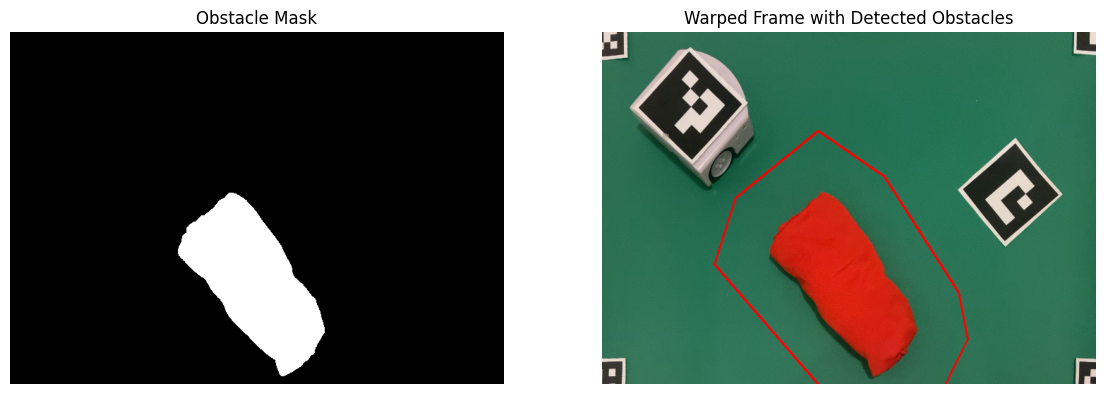

In [ ]:
warped_frame = vision.get_warped_frame()
obstacles, obstacle_mask = vision.detect_obstacles()
obstacles_frame = vision.draw(frame = warped_frame, obstacles = obstacles)

fig, axs = plt.subplots(1,2, figsize=(14,6))
axs[0].imshow(obstacle_mask, cmap='gray')
axs[0].set_title("Obstacle Mask")
axs[0].axis('off')
axs[1].imshow(cv2.cvtColor(obstacles_frame, cv2.COLOR_BGR2RGB))
axs[1].set_title("Warped Frame with Detected Obstacles")
axs[1].axis('off')
plt.show()

thymio and goal detection explanation

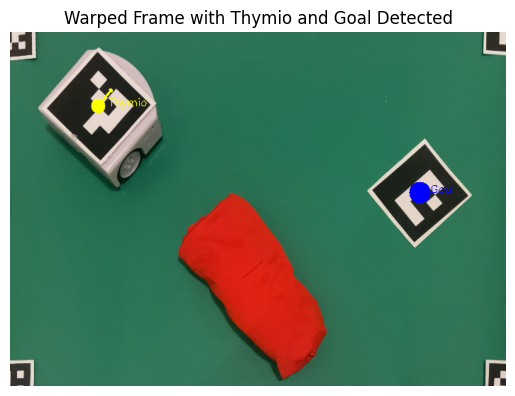

In [ ]:
warped_frame = vision.get_warped_frame()
thymio_pose = vision.get_thymio_pose(warped_frame)
goal_pos = vision.get_goal_pos(warped_frame)

pose_frame = vision.draw(frame = warped_frame, thymio_pose=thymio_pose, goal_pos=goal_pos)
plt.imshow(cv2.cvtColor(pose_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Warped Frame with Thymio and Goal Detected')
plt.show()


## Global Navigation

## Local Navigation

## Filtering

Extended Kalman filter
In real life, the robot’s position cannot be exactly defined as there are uncertainties from various sources such as sensor noise and motor friction. Hence, it is helpful to have measurements gathered in multiple way to increase the precision of the robot's localisation. To do so, the extended Kalman filter is used in this project to merge the data obtained from the robot’s encoder and position information from ARUCO markers scanned by webcam. 


With the covariance matrix Q and R obtained at the initialization phase, 

## Motion Control

## Overall Project
### Main function

The modules described previously are all merged in the main function. The main.py script orchestrates the flow of data between perception, planning, and control modules within a continuous asynchronous loop. The architecture is designed to be reactive, constantly updating its decisions based on the latest sensor readings and visual data. 

#### Initialization phase
Before the robot begins its mission, the system performs a critical setup sequence:
1. Connection: The script establishes a connection to the Thymio via the tdmclient. It "locks" the robot node to ensure exclusive control over the motors and sensors.
2. Vision Setup: The Vision class is instantiated. It attempts to load the calibration matrix. If the matrix is missing, it triggers the automated calibration routine.
3. Static Mapping: The system forces the camera to run for 2 seconds to adjust exposure/color and then captures a single stable image of the arena with static obstacles. It detects the red obstacles and generates the expanded polygons (C-Space) that will be used by the global path planner. This "static map" assumption allows us to compute the obstacle geometry only once, saving processing power for the main loop and also avoiding the Thymio to cover obstacles by changing the navigation plan without any real reason.


#### The control loop
Once initialized, the system enters a while True loop. Each iteration follows a strict Perceive-Plan-Act cycle:
##### Step 1: Perception
The robot gathers data from two independent sources:
* Camera: The camera captures a new frame. The Vision module processes this frame to find the current pose of the Thymio (Marker 0) and the Goal (Marker 1).
* Prox_sensors: The script reads the raw values from the Thymio's horizontal proximity sensors (prox.horizontal). It calculates the maximum value among the front sensors to detect imminent collisions.
##### Step 2: State estimation
Real-world data is noisy. The camera might flicker, or a shadow might obscure a marker. To handle this, we implemented a State Estimator with Resilience:
* If the marker is detected, the pose is updated, and the timestamp is recorded.
* If the marker is lost (detection fails), the system enters a "Coasting" mode. It assumes the robot is still at the last known valid position for a short duration (MAX_BLIND_DURATION = 0.5s).
* If the blindness persists beyond 0.5s, the system declares the robot "Lost" and triggers a safety stop.


## Conclusion